# Importacion de librerias

In [94]:
#%pip install numpy
# %pip install pandas
# $pip install matplotlib
# %pip install Pillow
# %pip install tqdm
# %pip install collections
# %pip install scikit-learn
# %pip install "dvc[s3]"

In [125]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import Counter

## Configuracion

In [126]:
CSV_PATH = "../data/csv/images_labels.csv"

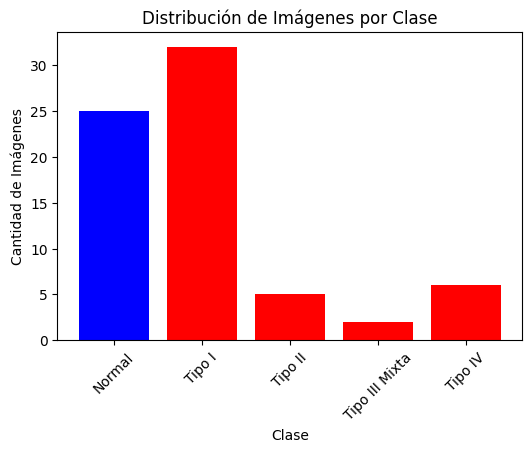

In [127]:
# graficar estos datos
from pandas import DataFrame

df = DataFrame({
    "class": ["Normal", "Tipo I", "Tipo II", "Tipo III Mixta", "Tipo IV"],
    "count": [25, 32, 5, 2, 6]
})

plt.figure(figsize=(6, 4))
plt.bar(df["class"], df["count"], color=["blue", "red", "red", "red", "red"])
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.title("Distribución de Imágenes por Clase")
plt.xticks(rotation=45)
plt.show()


# Cargar los datos

In [128]:
print("Current working directory:", os.getcwd())
df = pd.read_csv(CSV_PATH)
df.head()

Current working directory: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones/jupyter


,image_path,class
0,data/images/hernia/hernia38.tif,hernia
1,data/images/hernia/hernia39.tif,hernia
2,data/images/hernia/hernia11.png,hernia
3,data/images/hernia/hernia10.png,hernia
4,data/images/hernia/hernia1.png,hernia


## Descripción general del dataset

In [129]:
print("Total imágenes:", len(df))

print("\nClases:", df["class"].unique())

print("\nImágenes por clase:")
print(df["class"].value_counts())

Total imágenes: 70

Clases: <StringArray>
['hernia', 'normal']
Length: 2, dtype: str

Imágenes por clase:
class
hernia    45
normal    25
Name: count, dtype: int64


## Distribucion de clases

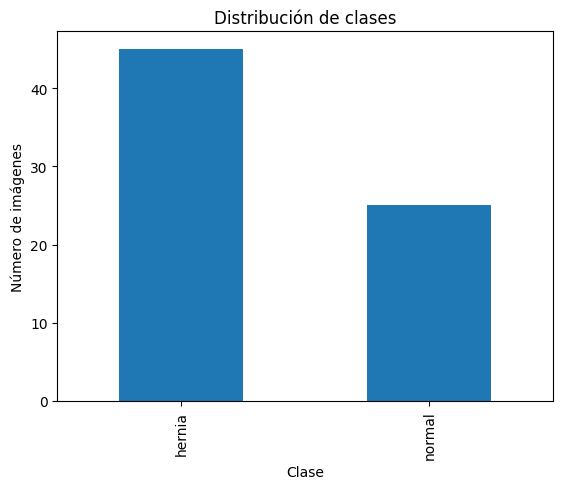

In [130]:
plt.figure()
df["class"].value_counts().plot(kind="bar")
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()

In [131]:
# Porcenataje de imágenes por clase
class_counts = df["class"].value_counts()
total_images = len(df)
for cls, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f"Clase: {cls}, Imágenes: {count}, Porcentaje: {percentage:.2f}%")

Clase: hernia, Imágenes: 45, Porcentaje: 64.29%
Clase: normal, Imágenes: 25, Porcentaje: 35.71%


## Estadisticas de dimensiones

In [132]:
data_info = []

for path in tqdm(df["image_path"]):
    path = "../" + path  # Ajustar el path si es necesario
    try:
        with Image.open(path) as img:
            width, height = img.size
            size_kb = os.path.getsize(path) / 1024
            channels = len(img.getbands())
            
            data_info.append((width, height, size_kb, channels))
    except:
        print (path)
        data_info.append((None, None, None, None))

df[["width", "height", "size_kb", "channels"]] = pd.DataFrame(data_info)

df.head()

print("Resolución promedio:")
print("Ancho medio:", df["width"].mean())
print("Alto medio:", df["height"].mean())

print("\nResoluciones únicas:")
print(df[["width", "height"]].drop_duplicates().head(10))

100%|██████████| 70/70 [00:00<00:00, 1963.64it/s]

Resolución promedio:
Ancho medio: 1086.3285714285714
Alto medio: 564.6857142857143

Resoluciones únicas:
    width  height
0    1225     629
1     975     945
2    1048     464
15   1048     490
33   1402     627
37   1163     582
38   1573     686
39   1171     855
40   1209     867
41   1221     976


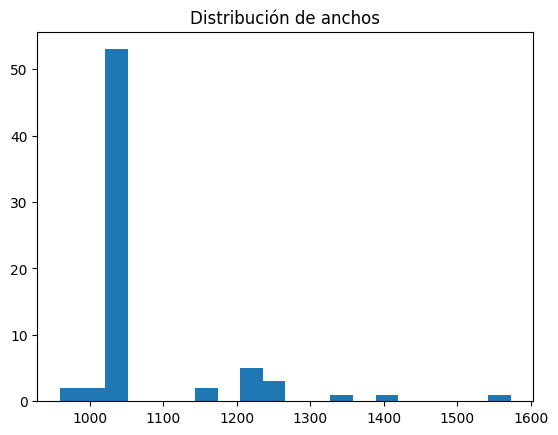

In [103]:
plt.figure()
plt.hist(df["width"], bins=20)
plt.title("Distribución de anchos")
plt.show()

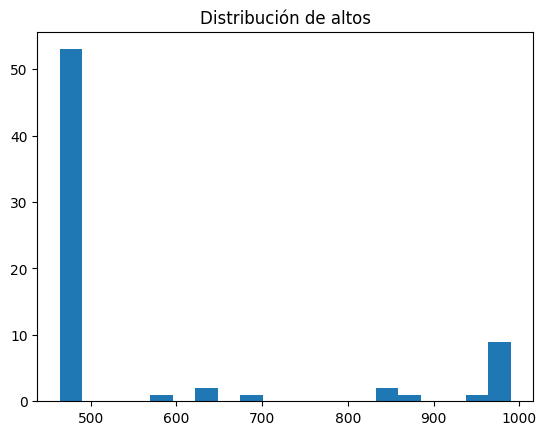

In [104]:
plt.figure()
plt.hist(df["height"], bins=20)
plt.title("Distribución de altos")
plt.show()

## Visualización de ejemplos por clase

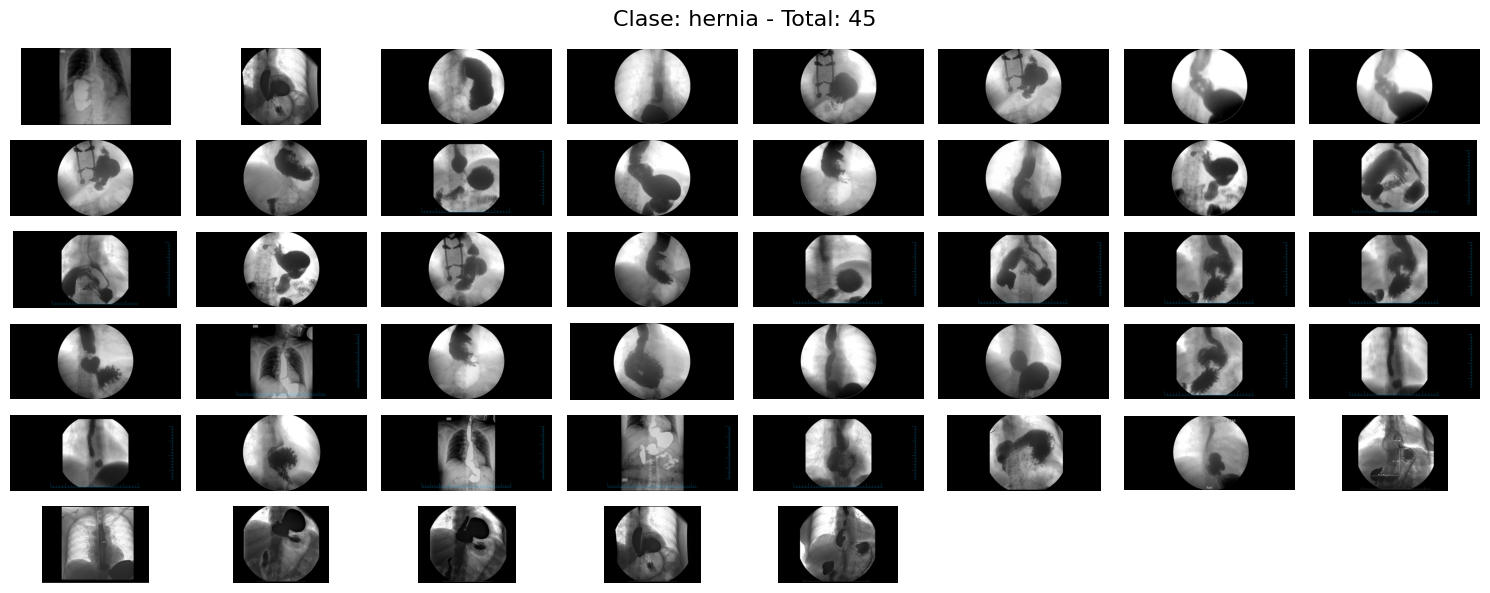

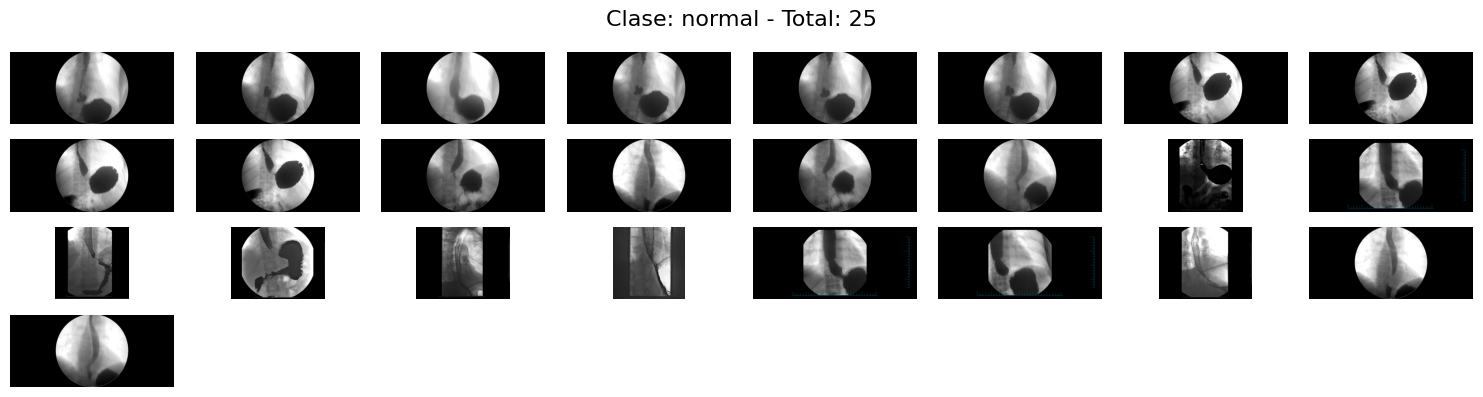

In [105]:
for cls in df["class"].unique():
    cls_images = df[df["class"] == cls]["image_path"].tolist()
    n_images = len(cls_images)
    n_cols = min(8, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 1 * n_rows))
    for i, path in enumerate(cls_images):
        path = "../" + path  # Ajustar el path si es necesario
        try:
            img = Image.open(path)
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except:
            print(f"Error al abrir la imagen: {path}")
    
    plt.suptitle(f"Clase: {cls} - Total: {n_images}", fontsize=16)
    plt.tight_layout()
    plt.show()


In [106]:
# Verificar porcentaje de cada clase
print("\nPorcentaje de cada clase:")
class_percentages = (df["class"].value_counts() / len(df) * 100).sort_values(ascending=False)
for cls, percentage in class_percentages.items():
    print(f"  {cls}: {percentage:.2f}%")

# Verificar clase dominante
max_percentage = class_percentages.max()
dominant_class = class_percentages.idxmax()
imbalance_ratio = class_percentages.max() / class_percentages.min()

print(f"\nClase dominante: {dominant_class} ({max_percentage:.2f}%)")

print(f"Ratio de desbalance: {imbalance_ratio:.2f}:1")



Porcentaje de cada clase:
  hernia: 64.29%
  normal: 35.71%

Clase dominante: hernia (64.29%)
Ratio de desbalance: 1.80:1


## Verificación de canales (RGB vs Grayscale)

In [107]:
print("Distribución de canales:")
print(df["channels"].value_counts())

Distribución de canales:
channels
4    69
3     1
Name: count, dtype: int64


## Análisis básico de intensidad (brillo)

In [108]:
def compute_mean_intensity(path):
    img = Image.open("../" + path).convert("L")
    arr = np.array(img)
    return arr.mean()

df["mean_intensity"] = df["image_path"].apply(compute_mean_intensity)

print(df["mean_intensity"].describe())

count    70.000000
mean     51.993635
std      11.840076
min      33.090201
25%      43.532636
50%      50.813413
75%      57.023896
max      92.208241
Name: mean_intensity, dtype: float64


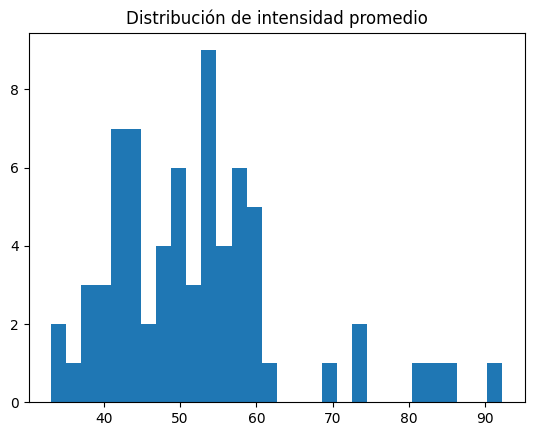

In [109]:
plt.figure()
plt.hist(df["mean_intensity"], bins=30)
plt.title("Distribución de intensidad promedio")
plt.show()

## Detección básica de imágenes atípicas

Umbral bajo (5%): 38.50
Umbral alto (95%): 77.53
Posibles imágenes atípicas: 8
                         image_path  mean_intensity
1   data/images/hernia/hernia39.tif       92.208241
25  data/images/hernia/hernia19.png       33.090201
34  data/images/hernia/hernia21.png       36.488471
40  data/images/hernia/hernia45.png       85.113969
59  data/images/normal/normal21.png       33.283984
62  data/images/normal/normal23.png       80.982642
64  data/images/normal/normal24.png       83.397777
66  data/images/normal/normal19.png       38.295941


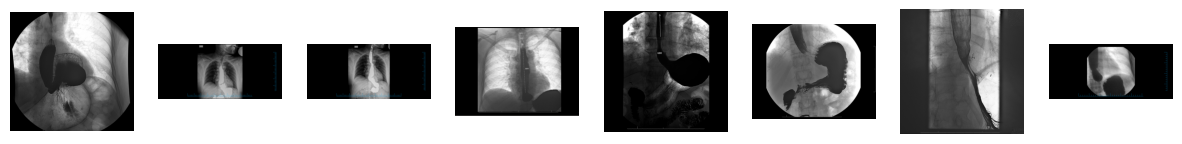

In [119]:
low_threshold = df["mean_intensity"].quantile(0.05)
high_threshold = df["mean_intensity"].quantile(0.95)

print(f"Umbral bajo (5%): {low_threshold:.2f}")
print(f"Umbral alto (95%): {high_threshold:.2f}")

outliers = df[(df["mean_intensity"] < low_threshold) | 
              (df["mean_intensity"] > high_threshold)]

print("Posibles imágenes atípicas:", len(outliers))

# Imprimir las imagenes atípicas
print(outliers[["image_path", "mean_intensity"]])

# Mostrar las imagenes atípicas en una fila
plt.figure(figsize=(15, 3))
for i, path in enumerate(outliers["image_path"]):
    path = "../" + path  # Ajustar el path si es necesario
    img = Image.open(path)
    plt.subplot(1, len(outliers), i + 1)
    plt.imshow(img)
    plt.axis("off")

## Division del dataset

In [111]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["class"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["class"],
    random_state=42
)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

Train: 49
Validation: 10
Test: 11


In [112]:
print("\nDistribución Train:")
print(train_df["class"].value_counts())

print("\nDistribución Validation:")
print(val_df["class"].value_counts())

print("\nDistribución Test:")
print(test_df["class"].value_counts())


Distribución Train:
class
hernia    32
normal    17
Name: count, dtype: int64

Distribución Validation:
class
hernia    6
normal    4
Name: count, dtype: int64

Distribución Test:
class
hernia    7
normal    4
Name: count, dtype: int64


## Guardar CSV estructurado

In [113]:
train_df.to_csv("../data/csv/train.csv", index=False)
val_df.to_csv("../data/csv/val.csv", index=False)
test_df.to_csv("../data/csv/test.csv", index=False)